In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from financial_parser import FinancialInfo

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = FinancialInfo(start_date='09.10.2008', end_date='01.05.2023').get_all()

Для удобства запишем результат работы кода из ячейки выше в файл:

In [4]:
df.to_csv('df_before_step03.csv')

In [5]:
# если нужно будет выгрузить через файл:
# df = pd.read_csv('df_before_step3.csv', index_col=0)

In [6]:
df.head()

,usdrub,gold,cb_key_rate,fed_rate,imoex_open,imoex_close,ru_cpi,us_cpi,workday
09.10.2008,26.1629,767.98,11.0,1.4,637.93,700.37,100.91,100.867301,workday
10.10.2008,26.0695,743.23,11.0,1.4,0.00,700.37,100.91,100.867301,workday
11.10.2008,26.2080,773.51,11.0,1.4,NaN,NaN,100.91,100.867301,day off
12.10.2008,NaN,NaN,11.0,1.4,NaN,NaN,100.91,100.867301,day off
13.10.2008,NaN,NaN,11.0,1.4,700.37,666.37,100.91,100.867301,workday


**Описание переменных:** 

* `gold` — Цена золота за грамм на определенную дату, в рублях
* `cb_key_rate` — Ставка Центрального банка РФ на определенную дату, в %
* `fed_rate` — Ставка Федеральной резервной системы США на определенную дату, в %
* `imoex_open` — Значение индекса IMOEX (Мосбиржи) на момент открытия торгов, в рублях
* `imoex_close` — Значение индекса IMOEX (Мосбиржи) на момент закрытия торгов, в рублях
* `ru_cpi` — Значение индекса потребительских цен (ИПЦ) РФ на конец месяца по отношению к предыдущему месяцу (н.: май к апрелю), в %
* `us_cpi` — Значение индекса потребительских цен (ИПЦ) США на конец месяца по отношению к предыдущему месяцу (н.: май к апрелю), в %
* `workday` - Рабочий или выходной день в РФ в определенную дату, принимает 2 значения: `workday` и `day off`

**Целевая переменная:** `usdrub` — Курс доллар/рубль на определенную дату, в рублях. Мы будем обучать модель предсказывать его значение

Добавим новые признаки: первый и второй рабочие дни после выходных. Экономический смысл, сокрытый за ними:
- `first_workday` - первый рабочий день после выходных. Тут может резко измениться значение IMOEX - это можно проверить
- `second_workday` - второй рабочий день после выходных. В него уже можно отследить и изменение индекса, и изменение курса доллара после выходных (т.к. Банк России в понедельник использует тот же курс, что был установлен в субботу)

In [7]:
df['first_workday'] = ((df['workday'] == 'workday') & (df['workday'].shift(1) == 'day off')).astype(int)
df['second_workday'] = df['first_workday'].shift(1).fillna(0).astype(int)

In [8]:
df.shape

(5316, 11)

In [9]:
df.dtypes

usdrub            float64
gold              float64
cb_key_rate       float64
fed_rate          float64
imoex_open        float64
imoex_close       float64
ru_cpi            float64
us_cpi            float64
workday            object
first_workday       int64
second_workday      int64
dtype: object

__1) Пропуски__

In [10]:
df.isnull().sum().sort_values(ascending=False)

usdrub            1718
gold              1718
imoex_open        1675
imoex_close       1675
cb_key_rate       1082
us_cpi              59
ru_cpi              29
fed_rate             0
workday              0
first_workday        0
second_workday       0
dtype: int64

In [11]:
df[df['imoex_open'].isnull()].head()

,usdrub,gold,cb_key_rate,fed_rate,imoex_open,imoex_close,ru_cpi,us_cpi,workday,first_workday,second_workday
11.10.2008,26.2080,773.51,11.0,1.4,NaN,NaN,100.91,100.867301,day off,0,0
12.10.2008,NaN,NaN,11.0,1.4,NaN,NaN,100.91,100.867301,day off,0,0
18.10.2008,26.2505,676.02,11.0,1.4,NaN,NaN,100.91,100.867301,day off,0,0
19.10.2008,NaN,NaN,11.0,1.4,NaN,NaN,100.91,100.867301,day off,0,0
25.10.2008,27.0596,602.47,11.0,1.4,NaN,NaN,100.91,100.867301,day off,0,0


Видим, что значение IMOEX не спарсилось за все субботы и воскресенья, что в целом логично, тк это выходные дни и торгов в них нет. Поэтому удалим эти строки

In [12]:
df = df.drop(df[df['imoex_open'].isnull()].index)

In [13]:
df.isnull().sum().sort_values(ascending=False)

usdrub            822
gold              822
us_cpi             41
cb_key_rate        34
ru_cpi             20
fed_rate            0
imoex_open          0
imoex_close         0
workday             0
first_workday       0
second_workday      0
dtype: int64

Таким образом, у нас пропали практически все Nanы в ставке ЦБ, что говорит о том, что там тоже не парсились выходные. Но остались те пропуски, которые были в праздничные, при этом будние дни:

In [14]:
df[df['cb_key_rate'].isnull()].head()

,usdrub,gold,cb_key_rate,fed_rate,imoex_open,imoex_close,ru_cpi,us_cpi,workday,first_workday,second_workday
06.01.2014,NaN,NaN,NaN,0.25,1504.14,1466.15,100.59,99.758169,day off,0,0
08.01.2014,NaN,NaN,NaN,0.25,1465.99,1462.67,100.59,99.758169,day off,0,0
02.05.2014,NaN,NaN,NaN,0.25,1304.93,1304.84,100.90,99.810061,day off,0,0
03.11.2014,NaN,NaN,NaN,0.25,1488.15,1491.19,101.28,100.188621,day off,0,0
05.01.2015,NaN,NaN,NaN,0.25,1394.66,1435.66,103.85,100.641116,day off,0,0


ЦБ в праздники отдыхает, а вот `IMOEX` меняется, поэтому заполним их с помощью forward fill значением ставки, которое было на предыдущий день:

In [15]:
df['cb_key_rate'] = df['cb_key_rate'].ffill()

In [16]:
df.isnull().sum().sort_values(ascending=False)

usdrub            822
gold              822
us_cpi             41
ru_cpi             20
cb_key_rate         0
fed_rate            0
imoex_open          0
imoex_close         0
workday             0
first_workday       0
second_workday      0
dtype: int64

Значений ИПЦ нет с мая 2023 у США и с апреля 2023 у РФ:

In [17]:
df[df['us_cpi'].isnull()].head()

,usdrub,gold,cb_key_rate,fed_rate,imoex_open,imoex_close,ru_cpi,us_cpi,workday,first_workday,second_workday
02.03.2023,75.2513,4414.41,7.5,4.65,2284.87,2254.30,100.37,NaN,workday,0,0
03.03.2023,75.4729,4467.81,7.5,4.65,2250.12,2272.20,100.37,NaN,workday,0,0
06.03.2023,NaN,NaN,7.5,4.65,2286.20,2294.12,100.37,NaN,workday,1,0
07.03.2023,75.4728,4467.56,7.5,4.65,2294.32,2295.60,100.37,NaN,workday,0,1
09.03.2023,NaN,NaN,7.5,4.65,2295.03,2290.14,100.37,NaN,workday,1,0


In [18]:
df[df['ru_cpi'].isnull()].head()

,usdrub,gold,cb_key_rate,fed_rate,imoex_open,imoex_close,ru_cpi,us_cpi,workday,first_workday,second_workday
03.04.2023,NaN,NaN,7.5,4.9,2474.37,2473.32,NaN,NaN,workday,1,0
04.04.2023,77.9510,4961.49,7.5,4.9,2483.47,2480.45,NaN,NaN,workday,0,1
05.04.2023,79.3563,5060.12,7.5,4.9,2489.18,2500.80,NaN,NaN,workday,0,0
06.04.2023,79.4961,5136.25,7.5,4.9,2504.06,2498.30,NaN,NaN,workday,0,0
07.04.2023,80.6713,5267.29,7.5,4.9,2504.04,2508.39,NaN,NaN,workday,0,0


Поэтому просто избавимся от двух последних месяцев:

In [19]:
df = df.drop(df[df['us_cpi'].isnull()].index)

In [20]:
df.isnull().sum().sort_values(ascending=False)

usdrub            813
gold              813
cb_key_rate         0
fed_rate            0
imoex_open          0
imoex_close         0
ru_cpi              0
us_cpi              0
workday             0
first_workday       0
second_workday      0
dtype: int64

Количество пропусков в `usdrub` и `gold` одинаковое, и пропущены значения именно за все понедельники:

In [21]:
df[df['gold'].isnull()].head()

,usdrub,gold,cb_key_rate,fed_rate,imoex_open,imoex_close,ru_cpi,us_cpi,workday,first_workday,second_workday
13.10.2008,NaN,NaN,11.0,1.4,700.37,666.37,100.91,100.867301,workday,1,0
20.10.2008,NaN,NaN,11.0,1.4,599.77,626.42,100.91,100.867301,workday,1,0
27.10.2008,NaN,NaN,11.0,1.4,0.00,513.62,100.91,100.867301,workday,1,0
05.11.2008,NaN,NaN,11.0,0.9,769.34,775.19,100.83,101.802461,workday,1,0
10.11.2008,NaN,NaN,11.0,1.0,725.93,741.51,100.83,101.802461,workday,1,0


- С `usdrub` так произошло потому, что ЦБ определяет курс иностранных валют по отношению к рублю каждый рабочий день в 11:30, но действовать он начинает лишь со следующего дня.
- А цена `gold` пересчитывается в рубли по официальному курсу доллара США к российскому рублю, действующему на день, следующий за днем установления учетных цен

ЦБ заявляет, что курс, устанавливаемый в пятницу, действует в субботу, воскресенье и понедельник (однако почему-то не проставил значения курса на понедельник). Поэтому заполним пропущенные значения с помощью forward fill:

In [22]:
df['usdrub'] = df['usdrub'].ffill()

In [23]:
df['gold'] = df['gold'].ffill()

In [24]:
df.isnull().sum().sort_values(ascending=False)

usdrub            0
gold              0
cb_key_rate       0
fed_rate          0
imoex_open        0
imoex_close       0
ru_cpi            0
us_cpi            0
workday           0
first_workday     0
second_workday    0
dtype: int64

__2) Выбросы__

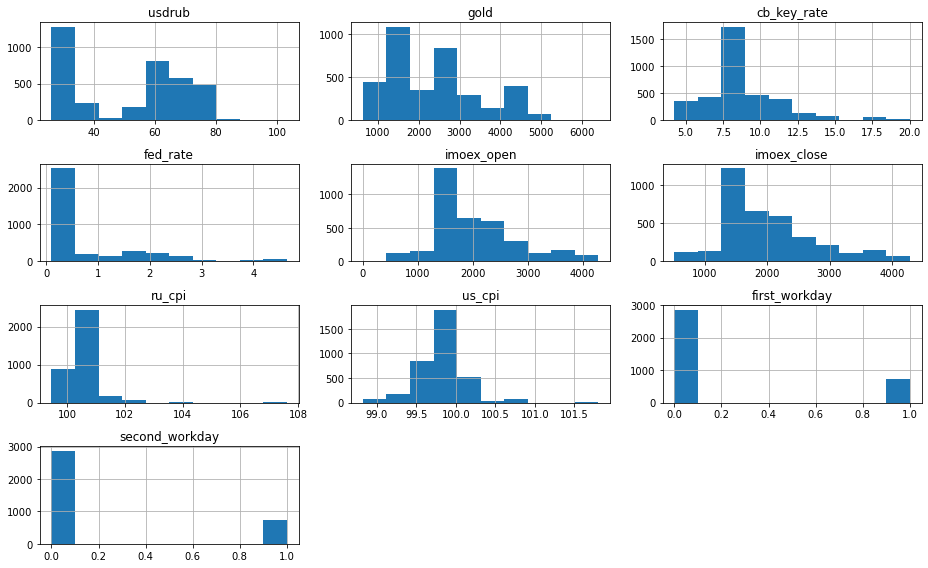

In [25]:
df.hist(figsize=(13,8))
plt.tight_layout();

Конечно, доллару слегка плохо, но мы попробуем посмотреть, что из этого выйдет дальше. Все остальные данные выглядят достаточно приятно, у распределений нет длинных хвостов либо резко выделяющихся значений.

Сохраним отредактированный набор данных в файл для последующих этапов:

In [26]:
df.to_csv('df_after_step03.csv')